In [2]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
import boto3
import boto3
import pandas as pd
from PIL import Image
import io

In [7]:


def read_aws_credentials(filename):
    credentials = {}
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials

creds_file = 'creds'
credentials = read_aws_credentials(creds_file)
aws_access_key_id = credentials.get('aws_access_key_id')
aws_secret_access_key = credentials.get('aws_secret_access_key')

s3_client = boto3.client(
    's3',
    region_name='eu-central-1',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)




In [ ]:
def find_pictures(bucket_name, prefix):
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    photos = []
    while True:
        for obj in response.get('Contents', []):
            if obj['Key'].endswith('.jpg'):
                photos.append(obj['Key'])
        if response['IsTruncated']:
            response = s3_client.list_objects_v2(
                Bucket=bucket_name, 
                Prefix=prefix, 
                ContinuationToken=response['NextContinuationToken']
            )
        else:
            break
    return photos



In [9]:
def read_image_data_from_s3(bucket_name, male_prefix, female_prefix):
    male_keys = find_pictures(bucket_name, male_prefix)
    female_keys = find_pictures(bucket_name, female_prefix)

    def create_df(photo_keys, gender):
        data = []
        for key in photo_keys:
            obj = s3_client.get_object(Bucket=bucket_name, Key=key)
            with Image.open(io.BytesIO(obj['Body'].read())) as img:
                width, height = img.size
                size = obj['ContentLength']
                image_info = {
                    'Filename': key.split('/')[-1],
                    'Path': key,
                    'Size': size,
                    'Width': width,
                    'Height': height,
                    'Gender': gender
                }
                data.append(image_info)
        return pd.DataFrame(data)

    male_df = create_df(male_keys, 'Male')
    female_df = create_df(female_keys, 'Female')

    return male_df, female_df



In [10]:
bucket_name = 'mypicturesmalefemale'
male_df, female_df = read_image_data_from_s3(bucket_name, 'male/', 'female/')

In [11]:
male_df

,Filename,Path,Size,Width,Height,Gender
0,male_006969.jpg,male/male_006969.jpg,15573,500,500,Male
1,male_006970.jpg,male/male_006970.jpg,4000,138,138,Male
2,male_006971.jpg,male/male_006971.jpg,3157,114,114,Male
3,male_006973.jpg,male/male_006973.jpg,8698,263,262,Male
4,male_006974.jpg,male/male_006974.jpg,17313,359,500,Male
5,male_006975.jpg,male/male_006975.jpg,14995,295,295,Male
6,male_006976.jpg,male/male_006976.jpg,22140,398,397,Male
7,male_006978.jpg,male/male_006978.jpg,8580,198,197,Male
8,male_006979.jpg,male/male_006979.jpg,13018,282,282,Male
9,male_006980.jpg,male/male_006980.jpg,25109,445,444,Male


In [12]:
male_df.shape

(11, 6)

In [13]:
female_df.shape

(11, 6)

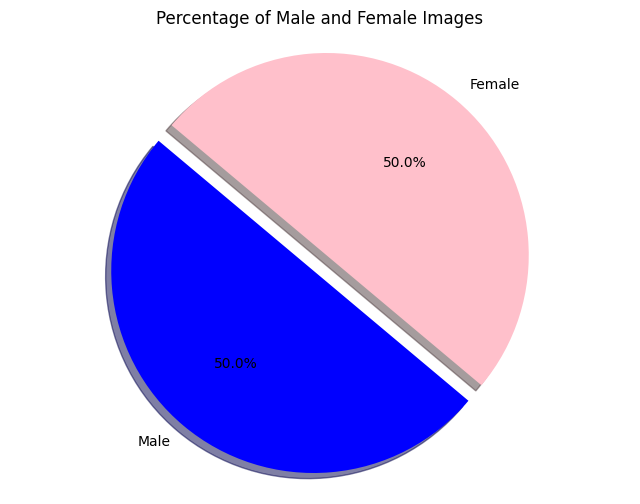

In [15]:
num_male = len(male_df)
num_female = len(female_df)
total = num_male + num_female
male_percentage = (num_male / total) * 100
female_percentage = (num_female / total) * 100
labels = 'Male', 'Female'
sizes = [male_percentage, female_percentage]
colors = ['blue', 'pink']
explode = (0.1, 0)
plt.figure(figsize=(8,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Male and Female Images')
plt.show()

/tmp/ipykernel_25925/2957186482.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([male_df['Width'], female_df['Width']], labels=['Male', 'Female'])
/tmp/ipykernel_25925/2957186482.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([male_df['Height'], female_df['Height']], labels=['Male', 'Female'])


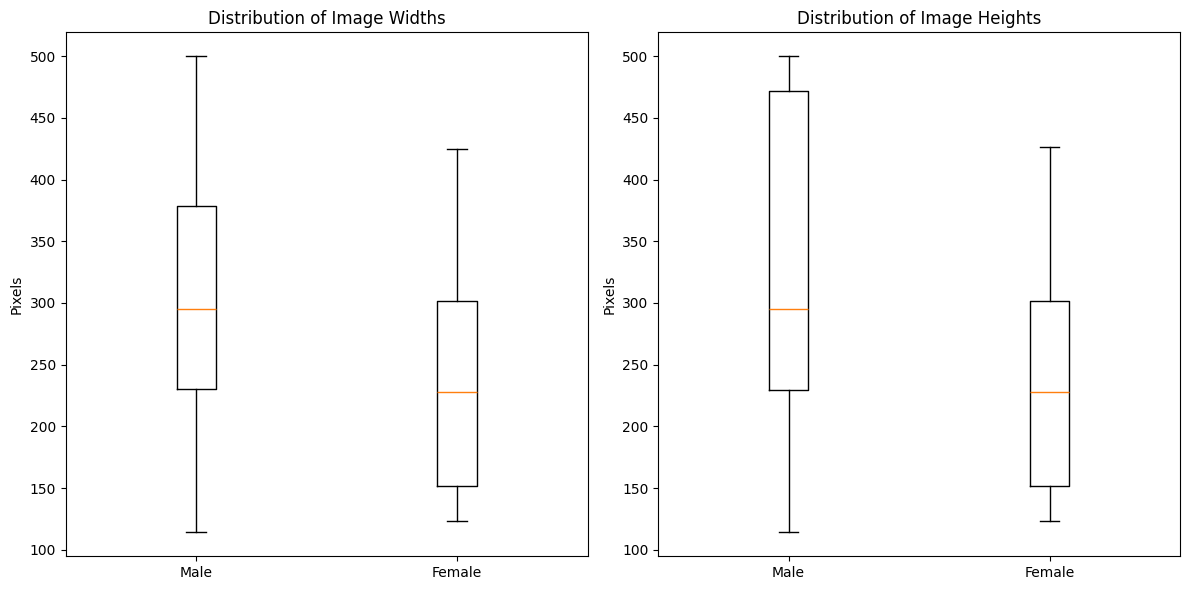

In [16]:
import matplotlib.pyplot as plt

def plot_boxplots(male_df, female_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot([male_df['Width'], female_df['Width']], labels=['Male', 'Female'])
    plt.title('Distribution of Image Widths')
    plt.ylabel('Pixels')

    # Plot for Heights
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.boxplot([male_df['Height'], female_df['Height']], labels=['Male', 'Female'])
    plt.title('Distribution of Image Heights')
    plt.ylabel('Pixels')

    plt.tight_layout()
    plt.show()
plot_boxplots(male_df, female_df)

In [17]:
def plot_size_distribution(male_df, female_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(male_df['Size'], bins=20, color='blue', alpha=0.7, label='Male Heights')
    plt.title('Distribution of Male Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(female_df['Size'], bins=20, color='pink', alpha=0.7, label='Female Heights')
    plt.title('Distribution of Female Image Heights')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
def plot_width_distribution(male_df, female_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(male_df['Width'], bins=20, color='blue', alpha=0.7, label='Male Heights')
    plt.title('Distribution of Male Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(female_df['Width'], bins=20, color='pink', alpha=0.7, label='Female Heights')
    plt.title('Distribution of Female Image Heights')
    plt.xlabel('width (pixels)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

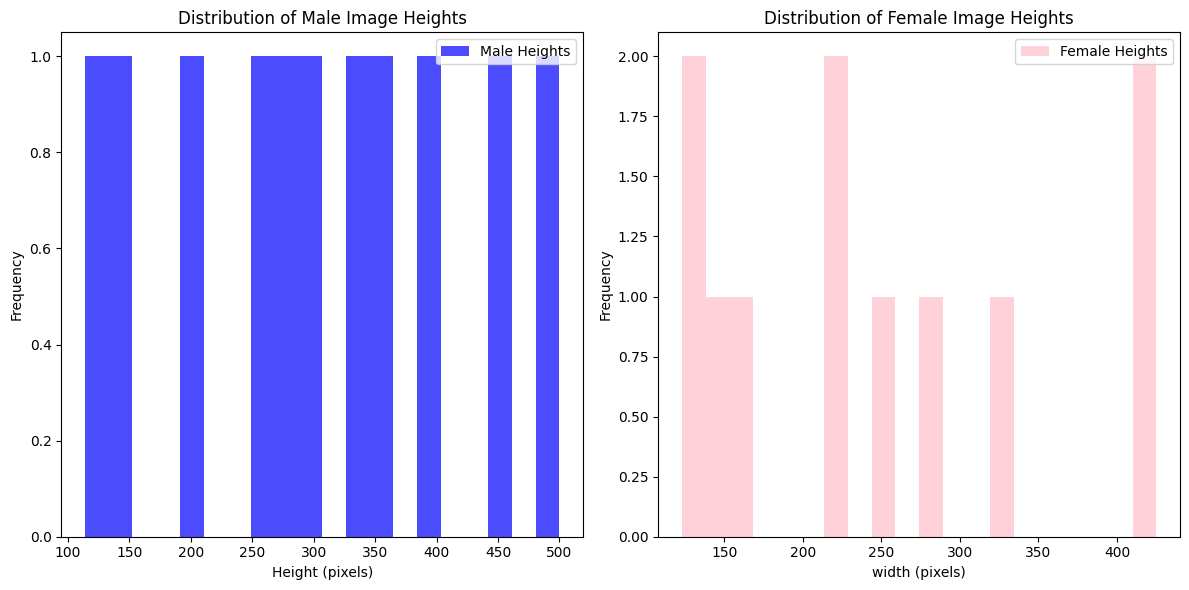

In [19]:

plot_width_distribution(male_df, female_df)

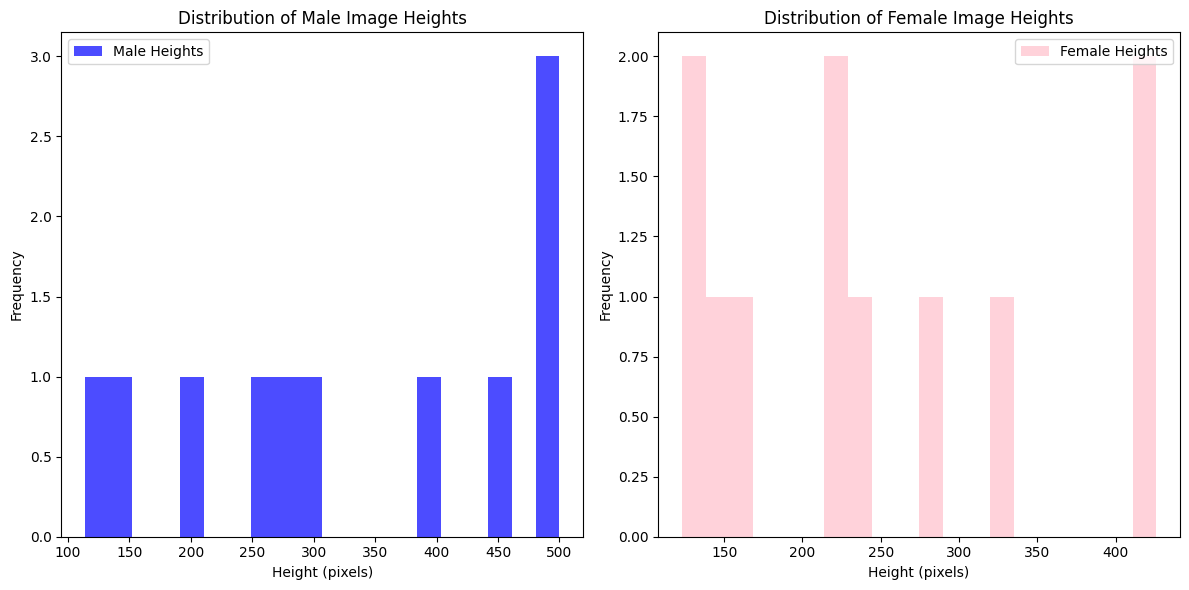

In [21]:
def plot_height_distribution(male_df, female_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(male_df['Height'], bins=20, color='blue', alpha=0.7, label='Male Heights')
    plt.title('Distribution of Male Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(female_df['Height'], bins=20, color='pink', alpha=0.7, label='Female Heights')
    plt.title('Distribution of Female Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_height_distribution(male_df, female_df)

In [22]:
def filter_by_dimension(df):
    filtered_df = df[(df['Width'] < 500) & (df['Height'] < 500)]
    return filtered_df

filtered_male_df = filter_by_dimension(male_df)
filtered_female_df = filter_by_dimension(female_df)

In [29]:

print("Filtered by Dimension - Male Images:", len(filtered_male_df))
print("Filtered by Dimension - Female Images:", len(filtered_female_df))

Filtered by Dimension - Male Images: 8
Filtered by Dimension - Female Images: 11


In [30]:
def resize_data_s3(bucket_name, key):
    obj = s3_client.get_object(Bucket=bucket_name, Key=key)
    img_data = obj['Body'].read()
    img = Image.open(io.BytesIO(img_data))
    img = np.array(img)  # Convert PIL image to numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert RGB to Gray (PIL reads in RGB by default)

    size = img.shape[0]
    if size >= 100:
        img = cv2.resize(img, (100, 100), cv2.INTER_AREA)
    else:
        img = cv2.resize(img, (100, 100), cv2.INTER_CUBIC)

    flatter_image = img.flatten()
    return flatter_image

# Assuming bucket_name is defined and filtered_male_df has a 'Key' column with S3 keys
filtered_male_df['data'] = filtered_male_df['Key'].apply(lambda key: resize_data_s3(bucket_name, key))

KeyError: 'Key'

In [28]:
filtered_male_df['data'] = filtered_male_df['Path'].apply(resize_data)

[ WARN:0@456.923] global loadsave.cpp:241 findDecoder imread_('male/male_006970.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
